# Siamese Segmentation Training

## Imports

In [1]:
# Jupyter Notebook utils
%load_ext autoreload
%matplotlib inline

In [19]:
import time
import os

from tqdm.notebook import tqdm
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt

import src.img_utils as utils
import src.model as siam_models
from src.datasets import iCoSegDataset
%autoreload 2

## Dataset Loading

### Constants

In [51]:
BATCH_SIZE = 2 # TODO: Allow changing
NUM_WORKERS = 1

IMAGES_PATH = "./icoseg_data/images_subset"
MASKS_PATH = "./icoseg_data/ground_truth_subset"

VALIDATION_SPLIT = 0.2 # What % the validation set should be
SHUFFLE = True

### Instantiation

In [55]:
dataset = iCoSegDataset(IMAGES_PATH, MASKS_PATH)

# Test/train dataset split
# Default is 80% training, 20% testing
dataset_length = len(dataset)
train_size = int((1.0 - VALIDATION_SPLIT) * dataset_length)
test_size = dataset_length - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=SHUFFLE
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=SHUFFLE,
    drop_last=True
)

## Training

### Constants

In [95]:
LEARNING_RATE = 0.00001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0004

SAVE_WEIGHTS = True
WEIGHTS_PATH = "./weights"

MARGIN_ALPHA = 0.25 # Parameter used in loss calculation

EPOCHS = 100

### Preparation

In [102]:
# Instantiation
device = None
if torch.cuda.is_available():
    print("Using CUDA 0 as device")
    device = torch.device("cuda:0")
else:
    print("Using CPU as device")
    device = torch.device("cpu")

prev_loss = float("inf")
model = siam_models.CoSegNet();

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)
model.to(device);

# Citerions
criterion_bce = nn.BCELoss()
# criterion_triplet = nn.TripletMarginLoss(margin=MARGIN_ALPHA)
# Using Cosine Embedding Loss as a similar loss to triplet
# due to prescence of pairs
criterion_cel = nn.CosineEmbeddingLoss(margin=MARGIN_ALPHA)

Using CUDA 0 as device


### Training Loop

In [105]:
for epoch in tqdm(range(EPOCHS), desc="Epoch Progress: "):
    # Losses and Loss Weights
    # Loss_final = W1*L1 + W2*L2 + W3*L3
    total_loss = 0
    loss_final = 0
    loss1A = 0 # Pixel-wise binary cross entropy
    loss1B = 0
    weight1 = 0
    loss2 = 0 # Triplet loss
    weight2 = 0
    loss3 = 0 # Cross Entropy
    weight3 = 0
    
    #Statistics
    predictions_correct = 0
    predictions_total = 0
    background_percent_correct = 0
    
    loader = tqdm(enumerate(train_loader), desc="Batch Progress: ", total=(train_size/BATCH_SIZE))
    
    model.train()
    
    time_start = time.time()
    
    for i, sample in loader:
        # Image Tensors
        imageA = sample["image"][0]
        imageB = sample["image"][1]
        # Mask Tensors
        maskA = sample["mask"][0].float().to(device)
        maskB = sample["mask"][1].float().to(device)
        # Labels
        labelA = sample["label"][0]
        labelB = sample["label"][1]
        
        # Normalizing images before sending to the model
        # Forming into batch-shape for processing
        norm_imageA = F.normalize(imageA,
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).unsqueeze(0)
        norm_imageB = F.normalize(imageB, 
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).unsqueeze(0)
        
        norm_imageA = norm_imageA.to(device)
        norm_imageB = norm_imageB.to(device)
        
        # Network Run
        pmapA, pmapB, vectorA, vectorB, decision = model(norm_imageA, norm_imageB)
        
        # Obtaining co-segmentation masks
        # based off of the decision by the decision net
        # During testing, the decision net's value
        # would be thresheld before multiplying
        pred_maskA = pmapA*decision
        pred_maskB = pmapB*decision
        
        # Loss Calculations/Evaluations
        # Configuring loss weights depending on sample
        # Also deciding if we produce a groundtruth mask
        truth = None
        pairwise = None
        if labelA == labelB: # Positive Sample found
            # Weighting loss evenly
            w1=w2=w3 = 0.33
            
            truth = 1
            pairwise = 1
        else: # Negative sample
            # Prevent Loss1 from backpropogating
            w1 = 0
            w2=w3 = 0.5
            
            # Create a null mask from the groundtruths
            maskA = maskA * 0
            maskB = maskB * 0
            
            truth = 0
            pairwise = -1
        
        # Loss 1
        # Pixel-wise Binary Cross Entropy Loss
        loss1A = criterion_bce(pred_maskA, maskA.unsqueeze(0).unsqueeze(0))
        loss1B = criterion_bce(pred_maskB, maskB.unsqueeze(0).unsqueeze(0))
        
        # Loss 2
        # Standard Triplet Loss with Margin
        pairwise = torch.tensor(pairwise).to(device)
        loss2 = criterion_cel(vectorA.unsqueeze(0), vectorB.unsqueeze(0), pairwise)
        
        # Loss 3
        # Binary Cross Entropy Loss
        truth = torch.tensor(truth).float().unsqueeze(0).to(device)
        loss3 = criterion_bce(decision, truth)
        
        loss_final = w1*(loss1A + loss1B) + w2*loss2 + w3*loss3
        
        loss_final.backward()
        optimizer.step()
        
        total_loss = total_loss + loss_final.item()
    
    print("Total Loss: " + str(total_loss))
    
    if total_loss < prev_loss and SAVE_WEIGHTS:
        # Check for dir, create if it doesn't exist
        if not os.path.exists(WEIGHTS_PATH):
            os.makedirs(WEIGHTS_PATH)
        
        prev_loss = total_loss
        print("Saving Model")
        torch.save(model.state_dict(), os.path.join(WEIGHTS_PATH, "CoSegNet_VGG16.path"))
        
        
    time_total = round(time.time() - time_start, 2)


Total Loss: 1.6927924305200577
Saving Model



Total Loss: 1.6602893471717834
Saving Model



Total Loss: 1.6928275525569916



Total Loss: 1.7734732776880264



Total Loss: 1.870010793209076



Total Loss: 1.945670872926712



Total Loss: 1.951790526509285



Total Loss: 1.8777571022510529



Total Loss: 1.7375290542840958



Total Loss: 1.566610112786293
Saving Model



Total Loss: 1.4196221083402634
Saving Model



Total Loss: 1.330006442964077
Saving Model



Total Loss: 1.3305239230394363



Total Loss: 1.408533088862896



Total Loss: 1.5383499562740326



Total Loss: 1.6761837750673294



Total Loss: 1.7656275629997253



Total Loss: 1.8159170299768448



Total Loss: 1.796944484114647



Total Loss: 1.7244201302528381



Total Loss: 1.6041111201047897



Total Loss: 1.4716791659593582



Total Loss: 1.345517821609974



Total Loss: 1.256837397813797
Saving Model



Total Loss: 1.221520982682705
Saving Model



Total Loss: 1.251066729426384



Total Loss: 1.306217521429062



Total Loss: 1.393511027097702



Total Loss: 1.4632043689489365



Total Loss: 1.4949854537844658



Total Loss: 1.4919632151722908



Total Loss: 1.4521089643239975



Total Loss: 1.3882318809628487



Total Loss: 1.321122132241726



Total Loss: 1.2985627725720406



Total Loss: 1.2938548177480698



Total Loss: 1.3346440717577934



Total Loss: 1.4024389162659645



Total Loss: 1.4722695127129555



Total Loss: 1.5289373993873596



Total Loss: 1.5576649606227875



Total Loss: 1.5467615649104118



Total Loss: 1.495627447962761



Total Loss: 1.4099234193563461



Total Loss: 1.2934547439217567



Total Loss: 1.1789302676916122
Saving Model



Total Loss: 1.0810576602816582
Saving Model



Total Loss: 1.0233119428157806
Saving Model



Total Loss: 1.0005386620759964
Saving Model



Total Loss: 1.0272977575659752



## Testing

tensor([1.], device='cuda:0', grad_fn=<SigmoidBackward>)


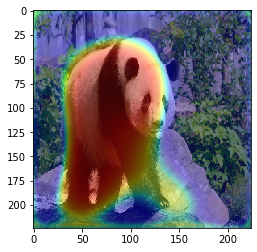

In [112]:
sample = next(iter(test_loader))

imageA = sample["image"][0].unsqueeze(0).to(device)
imageB = sample["image"][1].unsqueeze(0).to(device)

model.eval()
pmapA, pmapB, vectorA, vectorB, decision = model(imageA, imageB)

mapA = F.to_pil_image(pmapA.detach().cpu().squeeze())

imageA_cpu = F.to_pil_image(imageA.cpu().squeeze())
plt.imshow(imageA_cpu)
plt.imshow(mapA, cmap="jet", alpha=0.4)
plt.plot()

print(decision)
